# MP4: Audio Classification with Neural Networks


In this mini project, I dealt with audio signal processing by essentially creating Neural Networks using PyTorch to perform a classification task. 

We will make use of the `AudioMNIST` dataset: tens of thousands of audio samples of people with different accents, coming from different regions of the world, speaking different digits. The goal will be to train a neural network model that is able to solve the classification problem of identifying the correct digit label for the input audio signal.

### Importing Libraries

In [68]:
import glob
import random
import os

import numpy as np
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import IPython.display as ipd

### Creating the Dataset

We will begin by extracting Mel-frequency Cepstral Coefficients (MFCCs) from audio messages, a fundamental step in audio feature extraction. MFCCs are widely used for their effectiveness in capturing the essential characteristics of audio signals, making them an ideal choice for this classification task.

The dataset uploaded under 'data' in this repository consists of 60 folders, each one corresponding to a different speaker with a different accent. Each folder contains 500 audio files, with each one corresponding to a different utterance of a digit from 0 to 9.

Let's begin by playing one of the audio signals.

In [69]:
# Playing audio (kindly turn your volume up!)
sample_path = "data/02/1_02_0.wav"
ipd.Audio(sample_path)

Firstly we would have to think of a way to represent the input as features. One technique that lets us extract features from raw audio samples, is to calculate the MFCCs (Mel-Frequency Cepstral Coefficients) for each one. The main takeaway is that you now know a technique with which to *represent* an audio sample as a **fixed-size vector of features**.

We use the `librosa` library to perform the aforementioned operation.

In [70]:
# Grabing all the files ending with '.wav' using 'glob.glob' and using 'os' to conjoin the file path and the '.wav' extension
wav_paths = 'data/'
wav_paths = glob.glob(os.path.join(wav_paths, '**/*.wav'), recursive = True)
random.shuffle(wav_paths)

# Checking the total number of files as well as the correct file paths       
print("Wave Paths:", wav_paths)
print("Total Number of .wav Files:", len(wav_paths))

Wave Paths: ['data\\51\\9_51_37.wav', 'data\\13\\4_13_4.wav', 'data\\06\\8_06_28.wav', 'data\\21\\5_21_40.wav', 'data\\34\\0_34_4.wav', 'data\\26\\0_26_6.wav', 'data\\60\\1_60_35.wav', 'data\\37\\5_37_40.wav', 'data\\43\\1_43_20.wav', 'data\\23\\6_23_8.wav', 'data\\04\\7_04_21.wav', 'data\\59\\4_59_3.wav', 'data\\05\\4_05_33.wav', 'data\\37\\0_37_30.wav', 'data\\39\\6_39_13.wav', 'data\\55\\3_55_6.wav', 'data\\27\\4_27_0.wav', 'data\\46\\1_46_12.wav', 'data\\48\\3_48_18.wav', 'data\\24\\6_24_6.wav', 'data\\48\\3_48_47.wav', 'data\\36\\8_36_29.wav', 'data\\24\\7_24_36.wav', 'data\\30\\8_30_18.wav', 'data\\55\\6_55_36.wav', 'data\\04\\1_04_1.wav', 'data\\24\\2_24_27.wav', 'data\\13\\9_13_5.wav', 'data\\29\\2_29_10.wav', 'data\\43\\9_43_36.wav', 'data\\55\\0_55_47.wav', 'data\\42\\9_42_16.wav', 'data\\29\\1_29_48.wav', 'data\\35\\6_35_2.wav', 'data\\60\\5_60_2.wav', 'data\\29\\3_29_30.wav', 'data\\59\\2_59_4.wav', 'data\\51\\6_51_5.wav', 'data\\25\\0_25_4.wav', 'data\\28\\9_28_34.wav', 'd

In [71]:
# Function to extract the features from an individual audio sample
def generate_features(fpath):
    '''
    Generate 40 MFCC features from the argument audio file as input to the model
    '''
    # Loading in the file using librosa
    audio, sr = librosa.load(fpath) # returning the audio waveform and its sampling rate

    # Making sure that the audio is a Numpy array
    if not isinstance(audio, np.ndarray):
        raise ValueError("Audio data must be of type numpy.ndarray")

    # Trimming the audio file
    audio, _= librosa.effects.trim(audio)

    # Generating the MFCCs
    mfccs = librosa.feature.mfcc(y = audio, sr = sr, n_mfcc = 40)

    # Generating the features from the MFCCs by taking the mean of the transpose MFCCs along 0 axis
    mfccs_processed = np.mean(mfccs.T, axis = 0)
    return mfccs_processed

def get_label(fpath):
    '''
    Get the label from the filepath
    Example:
    1_23_4.wav -> 1
    '''
    # Getting the label
    label = int(fpath.split('\\')[2].split('_')[0])

    return label

def create_dataset(fnames):
    '''
    Create the dataset, i.e. features and labels, from the list of filepaths
    '''
    features = []
    labels = []
    
    for i, fpath in enumerate(fnames):
        if i % (len(fnames) // 10) == 0 or i == len(fnames)-1:
            print(f'Processing {i} of {len(fnames)} files')
        
        # Generating the features and label and appending both to the list
        features.append(generate_features(fpath))
        labels.append(get_label(fpath))
    
    return features, labels
    
# Creating the dataset using the function above
features, labels = create_dataset(wav_paths)

# Saving the features and labels for ease
np.save('features.npy', np.asarray(features))
np.save('labels.npy', np.asarray(labels))

# Loading both, 'features' and 'labels' into 'X' and 'y' respectively
X, y = np.load('features.npy'), np.load('labels.npy')
print("Features Shape:", X.shape, "Labels Shape:" , y.shape)

Processing 0 of 30000 files
Processing 3000 of 30000 files
Processing 6000 of 30000 files
Processing 9000 of 30000 files
Processing 12000 of 30000 files
Processing 15000 of 30000 files
Processing 18000 of 30000 files
Processing 21000 of 30000 files
Processing 24000 of 30000 files
Processing 27000 of 30000 files
Processing 29999 of 30000 files
Features Shape: (30000, 40) Labels Shape: (30000,)


In [72]:
# Converting to tensors
X = torch.tensor(X)
y = torch.tensor(y)

# Creating a train-test split (stratify using the labels to ensure that the target variable (class labels) are similarly distributed, resolving issues with imbalanced classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 420, stratify = y)
print("x_train:", X_train.shape)
print("y_train:" , y_train.shape)
print("x_test:" , X_test.shape)
print("y_test:" , y_test.shape)

x_train: torch.Size([24000, 40])
y_train: torch.Size([24000])
x_test: torch.Size([6000, 40])
y_test: torch.Size([6000])


###  Creating and Training an Audio Classifier


Now that we have finally gotten the dataset in a numericalized form fit for a model, we move to creating the actual model. We will be using PyTorch to create a Neural Network that can classify the audio samples.

Some important points relating to the network are provided below:
- You need to make use of `torch.nn` when creating the model.

- The input size of the model should be the same as the size of the feature vectors.

- The output size of the model should be 10, since there are 10 classes. Note that this also implies that we should be using the Cross Entropy Loss function (which is `nn.CrossEntropyLoss` in PyTorch).

- We can make any sized model you want, but note that smaller architectures train faster and work well for this task.

- There must be non-linear activation functions between the layers: try `nn.ReLU` or `nn.Tanh`.

In [73]:
# Creating an AudioClassifier class
class AudioClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

# Defining the input size, hidden size, and number of classes
input_size = 40  
hidden_size = 128
num_classes = 10

# Initializing the model
model = AudioClassifier(input_size, hidden_size, num_classes)

# Creating the loss function
loss_fn = nn.CrossEntropyLoss()

# Creating the optimizer (Adam)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

The last step is to create **training and evaluation** loops for the model.

In [74]:
# Function for one complete pass through of the entire training dataset 
def fit_one_epoch(model,
                  X, y,
                  optimizer, loss_fn):
    '''
    Perform one epoch of training
    '''
    # Setting the model in train mode
    model.train()
    
    # Implementing the Forward Pass
    logits = model(X)

    # Calculating the loss
    loss = loss_fn(logits, y.long())

    # Defning the Optimizer zero grad
    optimizer.zero_grad()

    # Implementing the Backward pass
    loss.backward()

    # Stepping the optimizer
    optimizer.step()

    # Calculating the accuracy
    # Hint: Take the argmax of the logits along the last axis and compare with y
    _, predicted = torch.max(logits, 1)
    correct = (predicted == y).sum()
    accuracy = correct / y.size(0)

    return loss.item(), accuracy
    

@torch.no_grad()
def evaluate(model,
             X, y,
             loss_fn):
    '''
    Perform one epoch of evaluation
    '''
    # Setting the model in eval mode
    model.eval()

    # Implementing the Forward Pass
    logits = model(X)

    # Calculating the loss
    loss = loss_fn(logits, y.long())

    # Calculating the accuracy
    _, predicted = torch.max(logits, 1)
    correct = (predicted == y).sum()
    acc = correct / y.size(0)

    return loss.item(), acc.item()

def fit(model,
        X_train, y_train, X_val, y_val,
        optimizer, loss_fn,
        epochs = 200):
    '''
    Perform the entire training process
    '''

    # Creating a history object to store the losses and accuracies
    history = {k: [] for k in ["train_loss", "train_acc", "val_loss", "val_acc"]}
    
    for epoch in range(epochs):
        # Training step
        train_loss, train_acc = fit_one_epoch(model, X_train, y_train, optimizer, loss_fn)
        
        # Evaluation step
        val_loss, val_acc = evaluate(model, X_val, y_val, loss_fn)
        
        # Logging the loss and accuracy for convenience
        if epoch % (epochs//10) == 0 or epoch == epochs-1:
            print(f"Epoch {epoch} | Train loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")

        # Save the losses and accuracies to the history object    
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
    
    return history

In [75]:
# Fitting the model and plotting the losses
history = fit(model, X_train, y_train, X_test, y_test, optimizer, loss_fn, epochs = 5000)

# Saving the model
torch.save(model.state_dict(), 'audio_classifier.pth')

Epoch 0 | Train loss: 11.3735 | Train Acc: 0.1000 | Val loss: 9.0664 | Val acc: 0.1023
Epoch 500 | Train loss: 0.2622 | Train Acc: 0.9070 | Val loss: 0.2650 | Val acc: 0.9072
Epoch 1000 | Train loss: 0.1773 | Train Acc: 0.9392 | Val loss: 0.1914 | Val acc: 0.9327
Epoch 1500 | Train loss: 0.1364 | Train Acc: 0.9536 | Val loss: 0.1590 | Val acc: 0.9430
Epoch 2000 | Train loss: 0.1054 | Train Acc: 0.9652 | Val loss: 0.1403 | Val acc: 0.9507
Epoch 2500 | Train loss: 0.0846 | Train Acc: 0.9723 | Val loss: 0.1286 | Val acc: 0.9555
Epoch 3000 | Train loss: 0.0687 | Train Acc: 0.9775 | Val loss: 0.1205 | Val acc: 0.9615
Epoch 3500 | Train loss: 0.0559 | Train Acc: 0.9820 | Val loss: 0.1206 | Val acc: 0.9598
Epoch 4000 | Train loss: 0.0466 | Train Acc: 0.9861 | Val loss: 0.1272 | Val acc: 0.9590
Epoch 4500 | Train loss: 0.0892 | Train Acc: 0.9699 | Val loss: 0.1510 | Val acc: 0.9548
Epoch 4999 | Train loss: 0.0484 | Train Acc: 0.9848 | Val loss: 0.1268 | Val acc: 0.9593


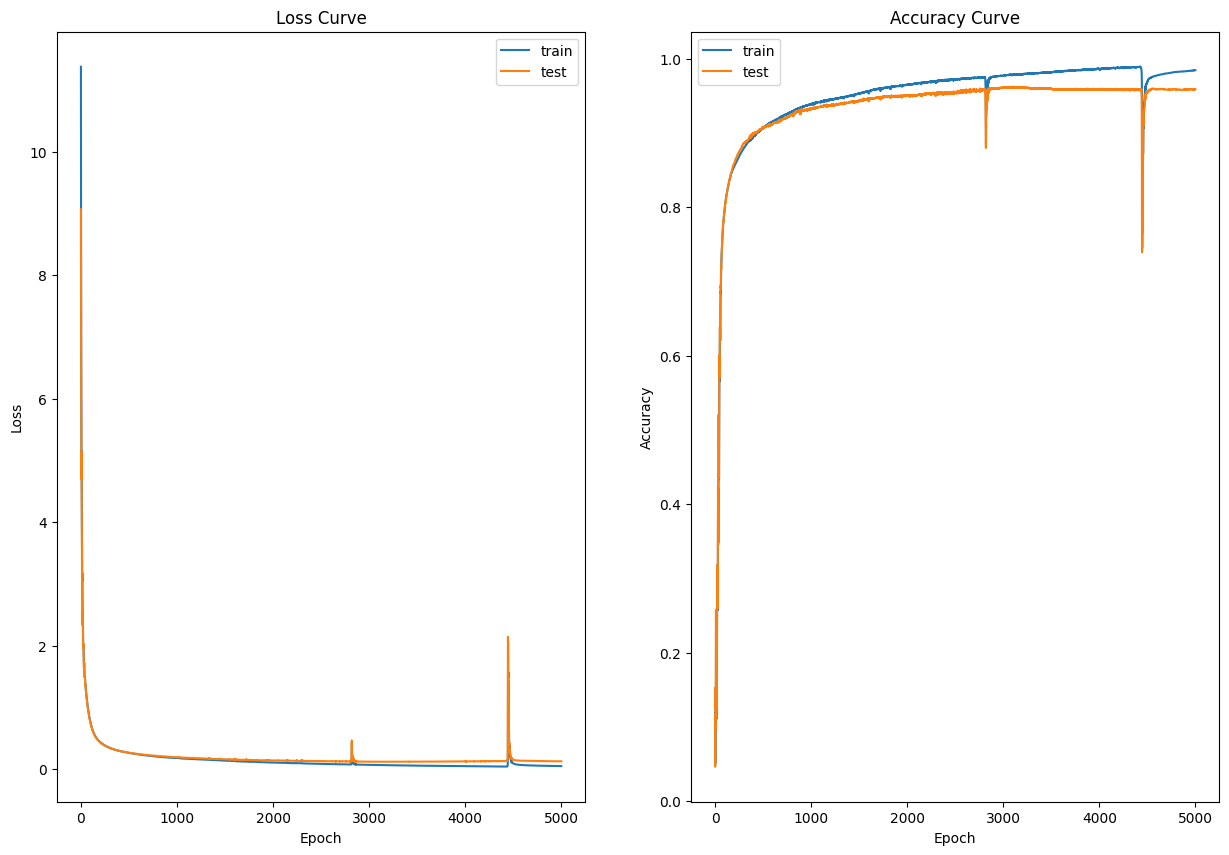

In [79]:
# Plotting the loss curves
plt.figure(figsize = (15, 10))

plt.subplot(121)
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss Curve")
plt.legend()

plt.subplot(122)
plt.plot(history['train_acc'], label='train')
plt.plot(history['val_acc'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy Curve")
plt.legend()

plt.show()

### Inference on a Custom Sample

Now that you've trained your model, you can use it to make predictions on custom audio samples. Note that you must apply the same preprocessing steps for feature extraction as before, since your model only knows and is configured to work for that.

In [77]:
@torch.no_grad()
def predict(fpth, model):
    '''
    Performs end-to-end inference on a sample audio file.
    '''
    # Preparing features
    mfccs_processed = generate_features(fpth)
    features = torch.FloatTensor(mfccs_processed)
    model.eval()
    logits = model(features)
    
    # Performing inference (getting the final prediction and the corresponding probability)
    probs = torch.softmax(logits, dim = 0)
    pred = torch.max(probs,dim=0)[1]
    probs = torch.max(probs,dim=0)[0]

    return pred, probs

In [119]:
x = random.choice(wav_paths)

pred, conf = predict(x, model)
print(f"Predicted class `{pred}` with confidence {(conf*100):.2f}%")

# Play the label
ipd.Audio(x)

Predicted class `1` with confidence 97.34%


Fin.